# Accessing and analysing a REMO dataset

In this notebook we want to show some typical data analysis that might be useful to look at after or during a REMO run.

In [1]:
import pyremo as pr
#from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm 
import intake
import fsspec
import seaborn as sns
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


<ipython-input-1-5657152f3db8>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


We will do the processing at DKRZ where we reserve a shared node for distributed computing with dask.

In [3]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:34530 Dashboard: /user/g300046/advanced//proxy/8787/status,Cluster Workers: 6 Cores: 24 Memory: 29.30 GiB


## Access and preparation of REMO output

For this notebook, we use 10 years of preliminary test results from a REMO run using ERA5 data as lateral boundary forcings. We will only use monthly mean data for this analysis, so let's catch that data from the filesystem:

In [7]:
import glob
pattern = '/work/ch0636/g300046/remo_results_056000/*/e056000m*.nc'
filenames = glob.glob(pattern)
filenames.sort()
filenames[:5]

['/work/ch0636/g300046/remo_results_056000/1979/e056000m197901.nc',
 '/work/ch0636/g300046/remo_results_056000/1979/e056000m197902.nc',
 '/work/ch0636/g300046/remo_results_056000/1979/e056000m197903.nc',
 '/work/ch0636/g300046/remo_results_056000/1979/e056000m197904.nc',
 '/work/ch0636/g300046/remo_results_056000/1979/e056000m197905.nc']

We will define a slightly different function for opening the monthly dataset that is based on some [xarray discussions on github](https://github.com/pydata/xarray/issues/1385#issuecomment-561920115).

In [15]:
def open_mfdataset(files, use_cftime=True, parallel=True, data_vars='minimal', chunks={'time':1}, 
                   coords='minimal', compat='override', drop=None, **kwargs):
    """optimized function for opening large cf datasets.

    based on https://github.com/pydata/xarray/issues/1385#issuecomment-561920115
    
    """
    def drop_all_coords(ds):
        #ds = ds.drop(drop)
        return ds.reset_coords(drop=True)
    ds = xr.open_mfdataset(files, parallel=parallel, decode_times=False, combine='by_coords', 
                       preprocess=drop_all_coords, decode_cf=False, chunks=chunks,
                      data_vars=data_vars, coords='minimal', compat='override', **kwargs)
    return xr.decode_cf(ds, use_cftime=use_cftime)



In [19]:
%time ds = open_mfdataset(filenames, parallel=True, chunks='auto')

CPU times: user 7.07 s, sys: 226 ms, total: 7.29 s
Wall time: 12.3 s


We now have our 10 years of monthly REMO output in one dataset. Please remember, that [xarray uses dask under the hood](http://xarray.pydata.org/en/stable/user-guide/dask.html) (if you have installed it!) which means that we can easily work and analyze large datasets that would normally not fit into our memory (or because we simply don't want all data loaded and slow us down).

For historical reason, the current REMO version sets the day of the month to 0 for monthly means. This is not compatible, e.g., with standard datetime formats. We provided a function to correct the time axis here.

In [22]:
from datetime import datetime as dt

time = list(ds.time.astype(str).values)
ds['time'] = [dt.strptime(t[0:6] , '%Y%m') for t in time]

Now, we have a reasonable time axis in the dataset that makes analysis much easier:

In [25]:
ds.time[:5]

<xarray.DataArray 'time' (time: 5)>
array(['1979-01-01T00:00:00.000000000', '1979-02-01T00:00:00.000000000',
       '1979-03-01T00:00:00.000000000', '1979-04-01T00:00:00.000000000',
       '1979-05-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 1979-05-01

Now, let's have a look at the dataset:

In [47]:
ds

<xarray.Dataset>
Dimensions:                     (height10m: 1, height2m: 1, lev_4: 1, lev_5: 1, meansea: 1, nhyi: 28, nhym: 27, rlat: 433, rlon: 433, snlevs: 3, time: 132)
Coordinates:
  * rlon                        (rlon) float64 -28.93 -28.82 ... 18.49 18.6
  * rlat                        (rlat) float64 -23.93 -23.82 ... 23.49 23.6
  * meansea                     (meansea) float64 0.0
  * height10m                   (height10m) float64 10.0
  * height2m                    (height2m) float64 2.0
  * lev_4                       (lev_4) float64 1.0
  * lev_5                       (lev_5) float64 27.0
  * snlevs                      (snlevs) float64 1.0 2.0 3.0
    lon                         (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
    lat                         (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
  * time                        (time) datetime64[ns] 1979-01-01 ... 1989-12-01
Dimensions without coordinates: nhyi, nhym
Data variables: (12/129)
    hyai                        (nhyi) float64 dask.array<chunksize=(28,), meta=np.ndarray>
    hybi                        (nhyi) float64 dask.array<chunksize=(28,), meta=np.ndarray>
    hyam                        (nhym) float64 dask.array<chunksize=(27,), meta=np.ndarray>
    hybm                        (nhym) float64 dask.array<chunksize=(27,), meta=np.ndarray>
    rotated_latitude_longitude  |S1 ...
    QDB                         (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    ...                          ...
    ALSOFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    USTRFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    VSTRFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    EVAPFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    TMCHFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    SNMLRHO                     (time, snlevs, rlat, rlon) float32 dask.array<chunksize=(1, 3, 433, 433), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.9.6 (http://mpimet...
    Conventions:          CF-1.6
    history:              Mon Mar 08 09:08:20 2021: cdo -t remo -f nc copy a0...
    source:               REMO
    institution:          Max-Planck-Institute for Meteorology
    CDO:                  Climate Data Operators version 1.9.6 (http://mpimet...
    forcing_file_format:  NetCDF
    remo_version:         2.0.0
    system:               Linux eddy3 2.6.32-754.33.1.el6.x86_64 #1 SMP Mon A...

You can see that we got 129 data variables and a lot of coordinates. We will focus on some common variables for analysis. However, first, let's look at the size of the dataset.

In [63]:
ds.nbytes / 1.e9 # in GB

12.476276945

Not too bad, 12 GB would fit into the memory, e.g. at DKRZ, but probably would be too large for a laptop. It's good that we load that dataset lazily and will only load data if we need it.

It's also handy to grep the pole information about the grid mapping from the dataset for plotting:

In [27]:
pole = ( ds.rotated_latitude_longitude.grid_north_pole_longitude,  ds.rotated_latitude_longitude.grid_north_pole_latitude)
pole

(-162.0, 39.25)

Finally, before we start, let's also define a plotting function for seasonal data that we will use later:

In [66]:
def plot_seasons(da, pole, vmin=None, vmax=None, cmap='coolwarm'):
    """plot seasonal means"""
    from matplotlib import pyplot as plt
    import cartopy.crs as ccrs
    transform = ccrs.RotatedPole(pole[1], pole[0])
    projection = transform
    #plt.subplots_adjust(hspace=1.5, wspace=1.0)
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(
        ncols=2, nrows=2, subplot_kw={'projection': projection}, 
        figsize=(18,14))
    
    axes = (ax1, ax2, ax3, ax4)
    for ax in axes:
        #ax.set_axis_off()
        ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', 
                      xlocs=range(-180,180,10), ylocs=range(-90,90,10))
        ax.coastlines(resolution='110m', color='black', linewidth=1)
    for season, ax in zip(da.season, axes):
        im = da.sel(season=season).plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, 
                                        transform=transform, add_colorbar=False)
    cbar = fig.colorbar(im, ax=axes)
    return plt

## Spin up

It's always useful to look at the soil temperatures. During the run, the soil has to get into an equilibrium with the atmospheric temperature to *forget* the initial conditions.

In [67]:
def vars_by_units(ds, units):
    temps = [var for var in ds if ds[var].attrs.get('units', None) == units]
    dim=xr.DataArray(data=temps, dims='var', name='var')
    return xr.concat([ds[var]-273.5 for var in temps], dim=dim)

Let's look at the following variables:

In [68]:
temp_vars = ['TS', 'TSL', 'TEMP2', 'TSN', 'TD3', 'TD4', 'TD5']

We will extract those variables from the big dataset and stuff them into a coordinate so that we can easily plot them.

In [69]:
dim = xr.DataArray(data=temp_vars, dims='var', name='var')
temps = xr.concat([ds[var] - 273.5 for var in temp_vars], dim=dim)
temps.name = 'temperatures'
temps

<xarray.DataArray 'temperatures' (var: 7, time: 132, rlat: 433, rlon: 433, height2m: 1)>
dask.array<concatenate, shape=(7, 132, 433, 433, 1), dtype=float32, chunksize=(1, 1, 433, 433, 1), chunktype=numpy.ndarray>
Coordinates:
  * height2m  (height2m) float64 2.0
  * rlon      (rlon) float64 -28.93 -28.82 -28.71 -28.6 ... 18.37 18.49 18.6
  * rlat      (rlat) float64 -23.93 -23.82 -23.71 -23.6 ... 23.37 23.49 23.6
    lon       (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
    lat       (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
  * time      (time) datetime64[ns] 1979-01-01 1979-02-01 ... 1989-12-01
  * var       (var) <U5 'TS' 'TSL' 'TEMP2' 'TSN' 'TD3' 'TD4' 'TD5'

Great, now lets' compute the spatial means (or field mean) for the 10 years...

In [70]:
temps_mean = temps.mean(dim=('rlat', 'rlon'))
temps_mean

,Array,Chunk
Bytes,3.61 kiB,4 B
Shape,"(7, 132, 1)","(1, 1, 1)"
Count,8316 Tasks,924 Chunks
Type,float32,numpy.ndarray


You can see that the data is still nicely chunked. We have not triggered any computation yet because we didn't actually look at the data yet. But now, we want to plot the data. To show the computation here, we will explicitly trigger it! Usually, you could just go on with plotting and the computation is done automatically.

In [72]:
from dask.distributed import progress
%time temps_mean_ = temps_mean.persist()  # start computation
%time progress(temps_mean_)

CPU times: user 453 ms, sys: 14 ms, total: 467 ms
Wall time: 714 ms
CPU times: user 7 ms, sys: 1e+03 µs, total: 8 ms
Wall time: 7.84 ms


VBox()

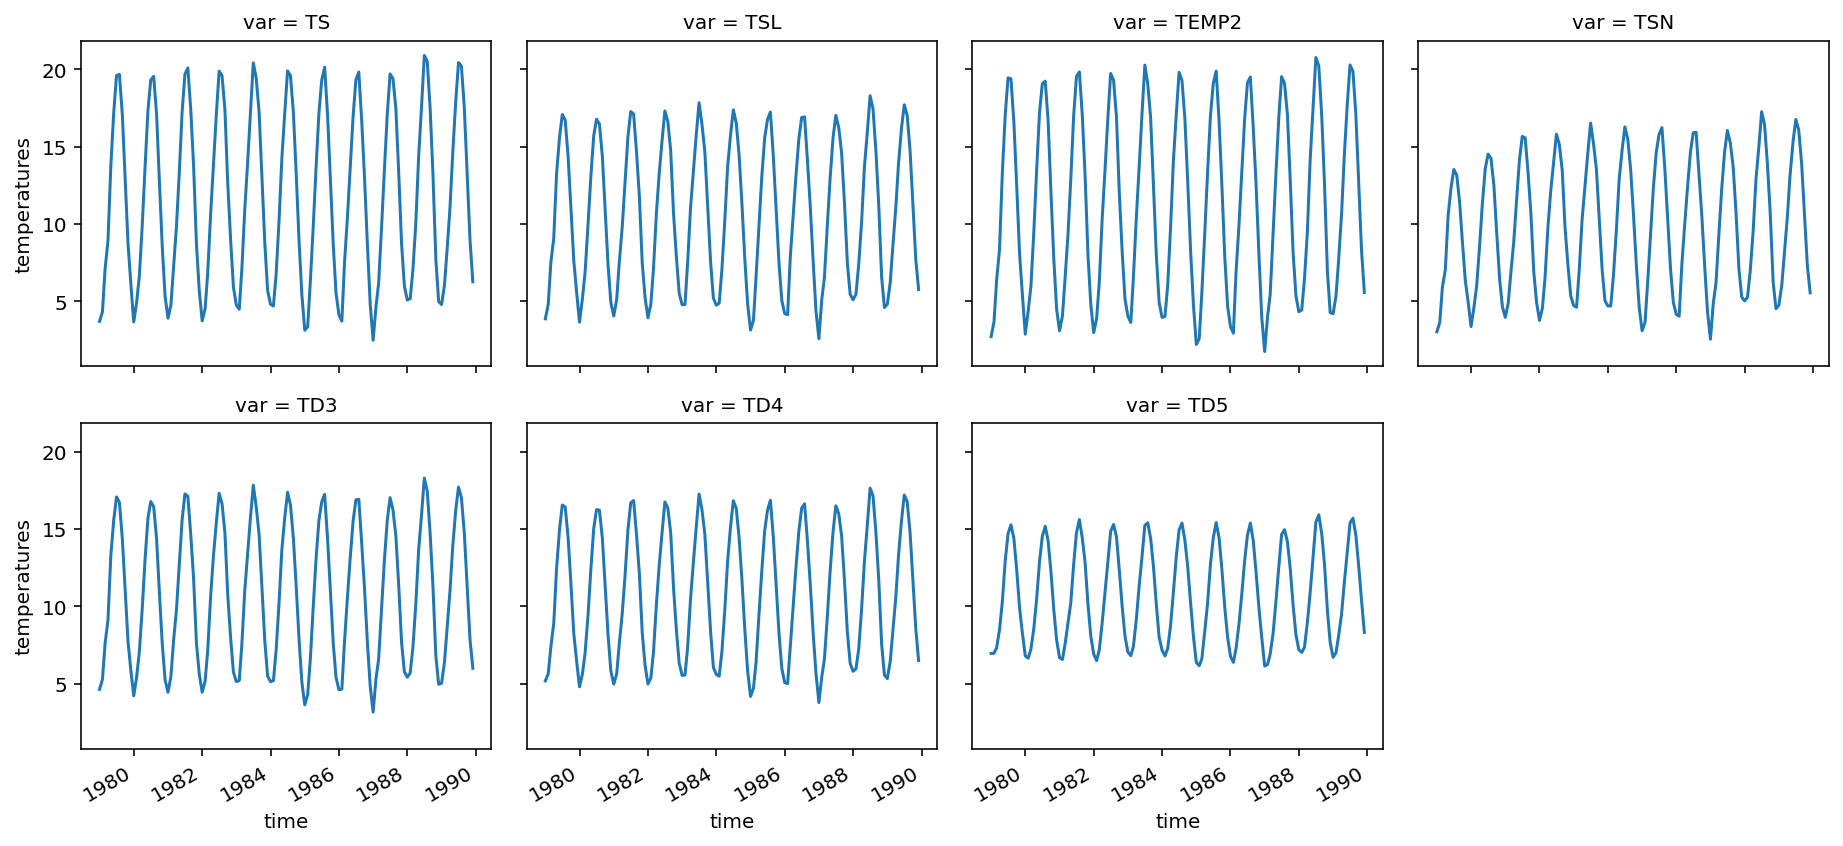

In [73]:
temps_mean_.plot(col='var', col_wrap=4)